In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np


In [4]:
from sklearn.model_selection import train_test_split

# Define data directory
data_dir = "labeled_data"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# Get image indices and labels
indices = np.arange(len(full_dataset))
labels = [full_dataset.targets[i] for i in range(len(full_dataset))]  # Get class indices

# Perform stratified split (70% train, 30% val)
train_idx, val_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)

# Create subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Classes:", class_names)
print(f"Total images: {len(full_dataset)}, Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Classes: ['chichi', 'gohan', 'goku', 'picolo', 'raditz']
Total images: 190, Train: 133, Val: 57


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet101 model
model = models.resnet101(pretrained=True)

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
    # param.requires_grad = True  # Freeze all layers

# Modify final layer for classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([1.0, 3.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001, weight_decay=1e-2)



In [8]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


Epoch [1/20], Loss: 1.5170, Accuracy: 38.35%
Epoch [2/20], Loss: 1.0560, Accuracy: 62.41%
Epoch [3/20], Loss: 0.9560, Accuracy: 60.15%
Epoch [4/20], Loss: 0.7774, Accuracy: 92.48%
Epoch [5/20], Loss: 0.6702, Accuracy: 87.97%
Epoch [6/20], Loss: 0.5078, Accuracy: 94.74%
Epoch [7/20], Loss: 0.4629, Accuracy: 92.48%
Epoch [8/20], Loss: 0.3867, Accuracy: 96.99%
Epoch [9/20], Loss: 0.4264, Accuracy: 95.49%
Epoch [10/20], Loss: 0.4569, Accuracy: 96.24%
Epoch [11/20], Loss: 0.3904, Accuracy: 96.24%
Epoch [12/20], Loss: 0.3201, Accuracy: 95.49%
Epoch [13/20], Loss: 0.2761, Accuracy: 95.49%
Epoch [14/20], Loss: 0.2894, Accuracy: 96.24%
Epoch [15/20], Loss: 0.2381, Accuracy: 98.50%
Epoch [16/20], Loss: 0.3289, Accuracy: 96.99%
Epoch [17/20], Loss: 0.2751, Accuracy: 97.74%
Epoch [18/20], Loss: 0.1977, Accuracy: 97.74%
Epoch [19/20], Loss: 0.2033, Accuracy: 96.24%
Epoch [20/20], Loss: 0.1930, Accuracy: 98.50%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


Actual: chichi, Predicted: goku


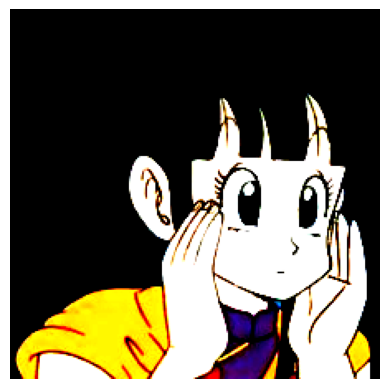

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


Actual: raditz, Predicted: gohan


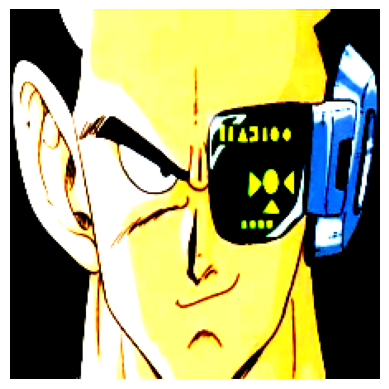

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Actual: chichi, Predicted: goku


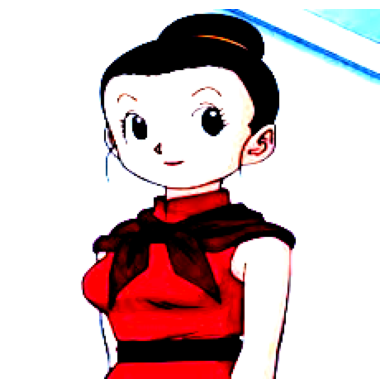

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Actual: gohan, Predicted: goku


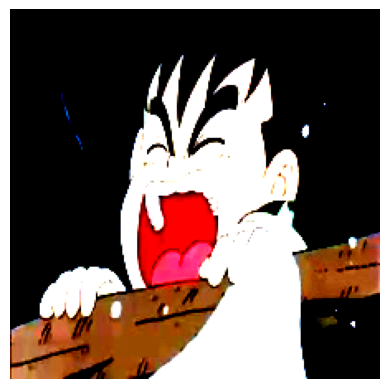

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


Actual: goku, Predicted: gohan


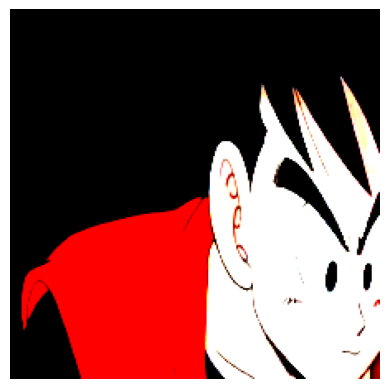

Validation Accuracy: 91.23%


In [9]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Function to display an image
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and rearrange dimensions
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.show()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Iterate through batch to display each image with its label
        for i in range(len(images)):
            if class_names[labels[i].item()] != class_names[predicted[i].item()]:
                print(f"Actual: {class_names[labels[i].item()]}, Predicted: {class_names[predicted[i].item()]}")
                imshow(images[i])  # Display the image

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


In [10]:
torch.save(model.state_dict(), "resnet101_trained.pth")
print("Model saved successfully!")


Model saved successfully!


In [11]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the number of classes (must match your training setup)
num_classes = len(class_names)  # Replace with actual number

# Load the ResNet101 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet101(pretrained=False)  # No need for pre-trained weights
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify last layer

# Load the trained weights
model.load_state_dict(torch.load("resnet101_trained.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode


/home/jebineinstein/git/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jebineinstein/git/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from PIL import Image
import torchvision.transforms as transforms

# Define image transformations (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet101 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)


In [13]:
def predict(image_path, model, class_names):
    image = preprocess_image(image_path)

    with torch.no_grad():  # No need to track gradients
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get class index

    predicted_class = class_names[predicted.item()]  # Get class label
    return predicted_class

# Define class labels (order must match training labels)
# class_names = ["chichi", "goku", "vegeta", "raditz"]  # Replace with your classes

# Predict an image
image_path = "download.png"  # Replace with an actual image path
result = predict(image_path, model, class_names)
print(f"Predicted Class: {result}")


Predicted Class: goku
